In [1]:
!pip install transformers==4.20.0
!pip install keras_nlp==0.3.0
!pip install datasets
!pip install huggingface-hub
!pip install nltk
!pip install rouge-score

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import logging
import nltk
import numpy as np
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers.data.data_collator import DataCollatorForSeq2Seq

2024-01-10 11:14:56.391418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 11:14:56.391455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 11:14:56.393223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 11:14:56.401340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 11:14:57.273378: W tensorflow/compiler/tf2

In [3]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
import keras_nlp
from keras.utils import pad_sequences

In [4]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vrsa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}



In [6]:
import re
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()

    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\\', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'-:,', '', text)
    text = re.sub(r'\.\b', '', text)
    text = re.sub(r'--|,', '', text)
    text = re.sub(r'\b\b', '', text)
    text = re.sub(r'\b\.\B', '', text)

    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)

   


    

    return text




In [7]:
def preprocess_dataset(df):
    df['article'] = df['article'].apply(clean_text)
    df['highlights'] = df['highlights'].apply(clean_text)

    if 'id' in df.columns:
        df = df.drop(['id'], axis=1)

    return df

In [38]:
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

model_path = "t5-small"

data_path = "cnn_dailymail", "3.0.0"

dataset = load_dataset("cnn_dailymail", "3.0.0")

train_dataset = dataset["train"]
print(len(train_dataset))
total_examples = len(train_dataset)

half = total_examples // 2
third = total_examples // 3
eith = total_examples // 60


train_dataset = train_dataset.select(range(eith))
print(len(train_dataset))

example = train_dataset[0] 
print(example)


287113
4785
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box

In [39]:
print(train_dataset[0]['highlights'])

print(len(train_dataset))

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .
4785


In [40]:
train_dataset = train_dataset.map(lambda example: {'article': clean_text(example['article']),
                                                    'highlights': clean_text(example['highlights'])})


In [41]:
print(train_dataset[0]['highlights'])

harry potter star daniel radcliffe gets £20m fortune turns 18 monday . young actor says plans fritter cash away . radcliffe s earnings first five potter films held trust fund .


In [42]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

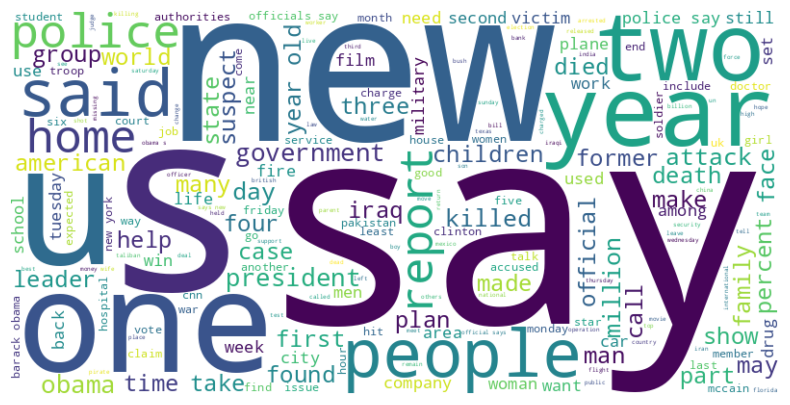

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
text = ' '.join(train_dataset['highlights'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
def tokenization(examples):
    inputs = ['summarize: ' + doc for doc in examples["article"]]
    tok = tokenizer(inputs, truncation=True, padding = True, return_tensors='tf')

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['highlights'],truncation=True, padding = True, return_tensors='tf')

    tok['labels'] = labels['input_ids']

    return {'input_ids': tok['input_ids'].numpy(),
            'labels': tok['labels'].numpy(),
            'attention_mask': tok['attention_mask'].numpy()}

In [45]:
tokenized_dataset = train_dataset.map(tokenization, batched=True)

processed_data = tokenized_dataset.remove_columns(['id','article', 'highlights'])

In [46]:
processed_data

Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 4785
})

In [47]:
final_dataset = processed_data.train_test_split(test_size=0.05
)
final_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 4545
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'attention_mask'],
        num_rows: 240
    })
})

In [48]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [49]:
import logging
logging.getLogger("external.local_xla.xla.stream_executor.cuda").setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.get_logger().setLevel(logging.WARN)

In [50]:
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
input_ids_train = [np.array(seq) for seq in final_dataset['train']['input_ids']]
attention_mask_train = [np.array(seq) for seq in final_dataset['train']['attention_mask']]
labels_train = [np.array(seq) for seq in final_dataset['train']['labels']]

In [52]:
max_sequence_length = 512

input_ids_train = pad_sequences(input_ids_train, maxlen=max_sequence_length)
attention_mask_train = pad_sequences(attention_mask_train, maxlen=max_sequence_length)
labels_train = pad_sequences(labels_train, maxlen=max_sequence_length)

In [53]:
X_train_tf = {'input_ids': tf.convert_to_tensor(input_ids_train),
              'attention_mask': tf.convert_to_tensor(attention_mask_train)}
y_train_tf = tf.convert_to_tensor(labels_train)

In [54]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Embedding, Masking, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.encoding = self.positional_encoding(max_len, d_model)

    def get_config(self):
        config = super().get_config().copy()
        return config

    def call(self, x):
        return x + self.encoding

    def positional_encoding(self, max_len, d_model):
        angle_rads = self.get_angles(np.arange(max_len)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])

        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates


def build_transformer_model(max_sequence_length, vocab_size, embedding_dim=128, num_heads=4, ff_dim=256, dropout=0.1):
    encoder_inputs = Input(shape=(max_sequence_length,))
    decoder_inputs = Input(shape=(max_sequence_length,))

    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)

    encoder_embedding = embedding_layer(encoder_inputs)
    decoder_embedding = embedding_layer(decoder_inputs)

    encoder_embedding = PositionalEncoding(max_sequence_length, embedding_dim)(encoder_embedding)
    decoder_embedding = PositionalEncoding(max_sequence_length, embedding_dim)(decoder_embedding)

    mask_layer = Masking(mask_value=0)

    encoder_masked = mask_layer(encoder_embedding)
    decoder_masked = mask_layer(decoder_embedding)

    encoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=dropout)
    decoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=dropout)

    encoder_ffn = Dense(ff_dim, activation='relu')
    encoder_ffn_out = encoder_ffn(encoder_masked)

    decoder_ffn = Dense(ff_dim, activation='relu')
    decoder_ffn_out = decoder_ffn(decoder_masked)

    encoder_attention_out = encoder_attention(query=encoder_ffn_out, value=encoder_ffn_out, key=encoder_ffn_out)
    encoder_attention_out = Add()([encoder_attention_out, encoder_ffn_out])
    encoder_attention_out = LayerNormalization(epsilon=1e-6)(encoder_attention_out)

    decoder_attention_out = decoder_attention(query=decoder_ffn_out, value=decoder_ffn_out, key=decoder_ffn_out)
    decoder_attention_out = Add()([decoder_attention_out, decoder_ffn_out])
    decoder_attention_out = LayerNormalization(epsilon=1e-6)(decoder_attention_out)

    decoder_dense = Dense(vocab_size, activation='softmax')
    outputs = decoder_dense(decoder_attention_out)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model

vocab_size = tokenizer.vocab_size
max_sequence_length = 512

model = build_transformer_model(max_sequence_length, vocab_size)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 512, 128)             4108800   ['input_4[0][0]']             
                                                                                                  
 positional_encoding_3 (Pos  (None, 512, 128)             0         ['embedding_1[1][0]']         
 itionalEncoding)                                                                                 
                                                                                                  
 masking_1 (Masking)         (None, 512, 128)             0         ['positional_encoding_3[

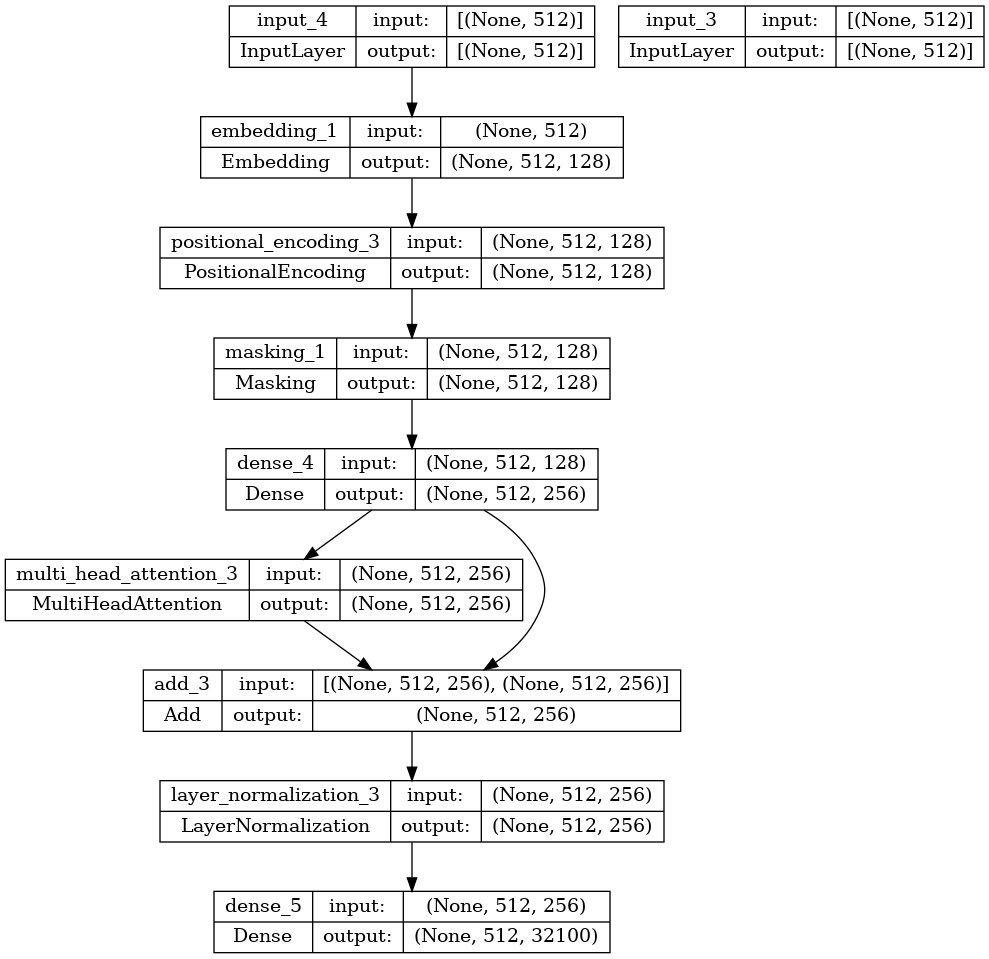

In [55]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'model_strukutura.png' ,show_shapes=True, show_layer_names=True)

In [56]:



model.fit(
    x=[input_ids_train, input_ids_train], 
    y=labels_train,  
    epochs=5,
    batch_size=3,
    validation_split=0.2)

Epoch 1/5
 653/1212 [===============>..............] - ETA: 41s - loss: 1.0611 - accuracy: 0.8889

W0000 00:00:1704882053.850881    7300 graph_launch.cc:161] Evict all gpu graphs from executor 0x5650e2be5f10


1212/1212 [==============================] - 103s 83ms/step - loss: 0.9707 - accuracy: 0.8902 - val_loss: 0.8634 - val_accuracy: 0.8916
Epoch 2/5
  31/1212 [..............................] - ETA: 1:26 - loss: 0.8450 - accuracy: 0.8920

W0000 00:00:1704882109.293260    7296 graph_launch.cc:161] Evict all gpu graphs from executor 0x5650e2be5f10


1212/1212 [==============================] - 100s 82ms/step - loss: 0.8489 - accuracy: 0.8920 - val_loss: 0.8554 - val_accuracy: 0.8916
Epoch 3/5
1212/1212 [==============================] - 100s 82ms/step - loss: 0.8338 - accuracy: 0.8925 - val_loss: 0.8518 - val_accuracy: 0.8920
Epoch 4/5
1212/1212 [==============================] - 100s 82ms/step - loss: 0.8220 - accuracy: 0.8928 - val_loss: 0.8566 - val_accuracy: 0.8918
Epoch 5/5
1212/1212 [==============================] - 100s 82ms/step - loss: 0.8103 - accuracy: 0.8933 - val_loss: 0.8634 - val_accuracy: 0.8919


In [57]:
model.save("transformer_model_tko_zna.h5")

/home/vrsa/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-01-10 11:28:26.749323: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32870400 exceeds 10% of free system memory.


In [63]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

max_sequence_length = 512

input_sequence=clean_text(dataset['train'][1]['article'])
input_ids_predict = pad_sequences(tokenizer(input_sequence, return_tensors='tf')['input_ids'], maxlen=max_sequence_length, padding='post', truncating='post')

predictions = model.predict([input_ids_predict, input_ids_predict])

print(predictions.shape)

max_prob_indices = np.argmax(predictions, axis=1)
decoded_tokens = tokenizer.batch_decode(max_prob_indices[0], skip_special_tokens=True)


print(input_sequence)
print(decoded_tokens)


1/1 [==============================] - 0s 17ms/step
(1, 512, 32100)
editor s note: behind scenes series cnn correspondents share experiences covering news analyze stories behind events here soledad o brien takes users inside jail many inmates mentally ill inmate housed "forgotten floor" many mentally ill inmates housed miami trial miami florida (cnn) ninth floor miami-dade pretrial detention facility dubbed "forgotten floor" here inmates severe mental illnesses incarcerated they re ready appear court often face drug charges charges assaulting officer charges judge steven leifman says usually "avoidable felonies" says arrests often result confrontations police mentally ill people often they re told police arrive scene confrontation seems exacerbate illness become paranoid delusional less likely follow directions according leifman so end ninth floor severely mentally disturbed getting real help they re jail toured jail leifman well known miami advocate justice mentally ill even though ex

In [64]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

max_sequence_length = 512

input_sequence=clean_text(dataset['train'][2]['article'])
print(input_sequence)
input_ids_predict = pad_sequences(tokenizer(input_sequence, return_tensors='tf')['input_ids'], maxlen=max_sequence_length, padding='post', truncating='post')

predictions = model.predict([input_ids_predict, input_ids_predict])
decoded_output = tokenizer.decode(tf.argmax(predictions, axis=1).numpy()[0], skip_special_tokens=True)

print("Input Text:", input_sequence)
print("Generated Output:", decoded_output)

minneapolis minnesota (cnn) drivers minneapolis bridge collapsed told harrowing tales survival "the whole bridge one side mississippi completely gave way fell way down" survivor gary babineau told cnn "i probably 30- 35-foot free fall there s cars water there s cars fire whole bridge down" said back injured determined could move around "i realized school bus right next me couple guys went started lifting kids bridge yelling screaming bleeding think broken bones" watch driver describe narrow escape » . home heard disaster dr john hink emergency room physician jumped car rushed scene 15 minutes arrived south side bridge stood riverbank saw dozens people lying dazed expansive deck middle mississippi river churning fast way getting them went north side easier access people ambulances also hard time driving river get closer scene working feverishly volunteers emts officials managed get 55 people ambulances less two hours occasionally pickup truck medic inside would drive get injured person 

In [65]:
file_path = "index_zivot_na_vagi_eng.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    index_text = file.read()
  
input_sequence = clean_text(index_text)
input_ids_predict = pad_sequences(tokenizer(input_sequence, return_tensors='tf')['input_ids'], maxlen=max_sequence_length, padding='post', truncating='post')

predictions = model.predict([input_ids_predict, input_ids_predict])
decoded_output = tokenizer.decode(tf.argmax(predictions, axis=1).numpy()[0], skip_special_tokens=True)

print("Input Text:", input_sequence)
print("Generated Output:", decoded_output)

1/1 [==============================] - 0s 15ms/step
Input Text: winner life scales mislav šepić index magazine 22:26 ​​january 4 2024 winner life scales mislav šepić +10 photo: press studio jadran film zagreb direction marijana batinić contestants seventh season life scales showed full glory hard work commitment past five months paid off first non-finalists fought prize 7500 euros showed results finalists fight 20000 euros - nina silvija mislav šepić goran secret finalist mislav vlašić - took stage way accompanied coaches faithful support support - mirna čužić edo mehmedović hide pride happiness saw contestants seventh season anđela akrap unfortunately could come due family obligations well krunoslav šuvak busy work ad first eliminated show continued practice outside returned show - marsela karamatić (28). told goes gym watches diet want give up irena changed habits irena pušec (48) also came completely changed habits leaves house every day sea family! leonardo prajo (25) admitted diff

In [66]:
#text = "Egypt has one of the longest histories of any country, tracing its heritage along the Nile Delta back to the 6th–4th millennia BCE. Considered a cradle of civilisation, Ancient Egypt saw some of the earliest developments of writing, agriculture, urbanisation, organised religion and central government.[14] Iconic monuments such as the Giza Necropolis and its Great Sphinx, as well the ruins of Memphis, Thebes, Karnak, and the Valley of the Kings, reflect this legacy and remain a significant focus of scientific and popular interest. Egypt's long and rich cultural heritage is an integral part of its national identity, which reflects its unique transcontinental location being simultaneously Mediterranean, Middle Eastern and North African.[15] Egypt was an early and important centre of Christianity, but was largely Islamised in the seventh century and remains a predominantly Sunni Muslim country, albeit with a significant Christian minority, along with other lesser practiced faiths."
input_sequence = " Reports of Cristiano Ronaldo's decline have been greatly exaggerated: The Real Madrid forward scored five goals against Granada, taking his tally in La Liga to 36 for the season - more than half of Europe's top teams. Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 at the Bernabeu, and their Portuguese talisman managed the first five-goal haul of his career. His record of 36 league goals for the season overtook Lionel Messi's 32 strikes, and put him in the incredible position of having scored more goals than 53 of the 98 teams in Europe's top five leagues this season. Cristiano Ronaldo scored an incredible five goals against Granada to lift his tally for the season to 36 . Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 . The Portuguese star now has more goals than 53 teams in Europe's top leagues, including nine in England . There are nine teams in the Barclays Premier League who have managed fewer goals in the league than Cristiano Ronaldo has this season. They are: . Stoke City, Newcastle United, West Bromwich Albion, Hull City, Aston Villa, Sunderland, Queens Park Rangers, Burnley and Leicester City. Ronaldo took some flak last month after a series of poor performances for Real, but his goalscoring has never waivered and even through a difficult period he managed six goals in 10 games, the sort of record most strikers can only dream of. And his displays across the season have brought more goals than the likes of Newcastle United, Malaga, Borussia Dortmund, Torino and Lille. The first three of his five goals against Granada marked the quickest hat-trick of his career, coming in just eight first half minutes. Another followed 16 minutes later, and his last came 35 minutes after that. Ronaldo's displays across the season have brought more goals than the likes of Borussia Dortmund and Lille . It all adds up to a brilliant Easter Sunday for the world's best player, and he spoke of his delight afterwards . Lionel Messi and Barcelona came out on top in El Clasico but he has fewer league goals than Ronaldo . Borussia Dortmund, who can boast Marco Reus among their ranks, have fewer goals than the Real talisman . While Ronaldo overtook Messi on the goalscoring charts, the hat-trick - which could have been doubled - levelled the Argentine's record of 24 La Liga trebles. He almost matched Real legend Alfredo Di Stefano's 28 hat-tricks for Los Blancos in what was their biggest league win in 48-and-a-half years. It all adds up to a brilliant Easter Sunday for the world's best player, and he posted on Twitter after the game, saying: 'Happy to have scored 5 goals with this excellent team work. Thank you for all your support.' If the critics still see Ronaldo as greedy, it certainly paid off at the Santiago Bernabeu on Sunday. Premier League: Stoke City, Newcastle United, West Bromwich Albion, Hull City, Aston Villa, Sunderland, Queens Park Rangers, Burnley, Leicester City. La Liga: Malaga, Athletic Bilbao, Rayo Vallecano, Real Sociedad, Celta Vigo, Espanyol, Getafe, Levante, Eibar, Elche, Deportivo la Coruna, Almeria, Granada, Cordoba. Bundesliga: Augsburg, Borussia Dortmund, Mainz, Cologne, Hertha Berlin, Freiberg, Hannover, Hamburg, Paderborn, Stuttgart. Serie A: Torino, Sassuolo, Udinese, Empoli, Chievo, Atalanta, Cesena, Cagliari, Parma. Ligue 1: Lille, Rennes, Nantes, Guingamp, Nice, Bastia, Evian, Lorient, Toulouse, Metz, Lens."
input_ids_predict = pad_sequences(tokenizer(input_sequence, return_tensors='tf')['input_ids'], maxlen=max_sequence_length, padding='post', truncating='post')

predictions = model.predict([input_ids_predict, input_ids_predict])
decoded_output = tokenizer.decode(tf.argmax(predictions, axis=1).numpy()[0], skip_special_tokens=True)

print("Input Text:", input_sequence)
print("Generated Output:", decoded_output)

1/1 [==============================] - 0s 16ms/step
Input Text:  Reports of Cristiano Ronaldo's decline have been greatly exaggerated: The Real Madrid forward scored five goals against Granada, taking his tally in La Liga to 36 for the season - more than half of Europe's top teams. Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 at the Bernabeu, and their Portuguese talisman managed the first five-goal haul of his career. His record of 36 league goals for the season overtook Lionel Messi's 32 strikes, and put him in the incredible position of having scored more goals than 53 of the 98 teams in Europe's top five leagues this season. Cristiano Ronaldo scored an incredible five goals against Granada to lift his tally for the season to 36 . Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 . The Portuguese star now has more goals than 53 teams in Europe's top leagues, including nine in England .

In [69]:
#text = "Egypt has one of the longest histories of any country, tracing its heritage along the Nile Delta back to the 6th–4th millennia BCE. Considered a cradle of civilisation, Ancient Egypt saw some of the earliest developments of writing, agriculture, urbanisation, organised religion and central government.[14] Iconic monuments such as the Giza Necropolis and its Great Sphinx, as well the ruins of Memphis, Thebes, Karnak, and the Valley of the Kings, reflect this legacy and remain a significant focus of scientific and popular interest. Egypt's long and rich cultural heritage is an integral part of its national identity, which reflects its unique transcontinental location being simultaneously Mediterranean, Middle Eastern and North African.[15] Egypt was an early and important centre of Christianity, but was largely Islamised in the seventh century and remains a predominantly Sunni Muslim country, albeit with a significant Christian minority, along with other lesser practiced faiths."
input_sequence = " Reports of Cristiano Ronaldo's decline have been greatly exaggerated: The Real Madrid forward scored five goals against Granada, taking his tally in La Liga to 36 for the season - more than half of Europe's top teams. Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 at the Bernabeu, and their Portuguese talisman managed the first five-goal haul of his career. His record of 36 league goals for the season overtook Lionel Messi's 32 strikes, and put him in the incredible position of having scored more goals than 53 of the 98 teams in Europe's top five leagues this season. Cristiano Ronaldo scored an incredible five goals against Granada to lift his tally for the season to 36 . Granada were torn to shreds by Ronaldo and his Real team-mates as the European champions won 9-1 . The Portuguese star now has more goals than 53 teams in Europe's top leagues, including nine in England . There are nine teams in the Barclays Premier League who have managed fewer goals in the league than Cristiano Ronaldo has this season. They are: . Stoke City, Newcastle United, West Bromwich Albion, Hull City, Aston Villa, Sunderland, Queens Park Rangers, Burnley and Leicester City. Ronaldo took some flak last month after a series of poor performances for Real, but his goalscoring has never waivered and even through a difficult period he managed six goals in 10 games, the sort of record most strikers can only dream of. And his displays across the season have brought more goals than the likes of Newcastle United, Malaga, Borussia Dortmund, Torino and Lille. The first three of his five goals against Granada marked the quickest hat-trick of his career, coming in just eight first half minutes. Another followed 16 minutes later, and his last came 35 minutes after that. Ronaldo's displays across the season have brought more goals than the likes of Borussia Dortmund and Lille . It all adds up to a brilliant Easter Sunday for the world's best player, and he spoke of his delight afterwards . Lionel Messi and Barcelona came out on top in El Clasico but he has fewer league goals than Ronaldo . Borussia Dortmund, who can boast Marco Reus among their ranks, have fewer goals than the Real talisman . While Ronaldo overtook Messi on the goalscoring charts, the hat-trick - which could have been doubled - levelled the Argentine's record of 24 La Liga trebles. He almost matched Real legend Alfredo Di Stefano's 28 hat-tricks for Los Blancos in what was their biggest league win in 48-and-a-half years. It all adds up to a brilliant Easter Sunday for the world's best player, and he posted on Twitter after the game, saying: 'Happy to have scored 5 goals with this excellent team work. Thank you for all your support.' If the critics still see Ronaldo as greedy, it certainly paid off at the Santiago Bernabeu on Sunday. Premier League: Stoke City, Newcastle United, West Bromwich Albion, Hull City, Aston Villa, Sunderland, Queens Park Rangers, Burnley, Leicester City. La Liga: Malaga, Athletic Bilbao, Rayo Vallecano, Real Sociedad, Celta Vigo, Espanyol, Getafe, Levante, Eibar, Elche, Deportivo la Coruna, Almeria, Granada, Cordoba. Bundesliga: Augsburg, Borussia Dortmund, Mainz, Cologne, Hertha Berlin, Freiberg, Hannover, Hamburg, Paderborn, Stuttgart. Serie A: Torino, Sassuolo, Udinese, Empoli, Chievo, Atalanta, Cesena, Cagliari, Parma. Ligue 1: Lille, Rennes, Nantes, Guingamp, Nice, Bastia, Evian, Lorient, Toulouse, Metz, Lens."
input_sequence = clean_text(input_sequence)
input_ids_predict = pad_sequences(tokenizer(input_sequence, return_tensors='tf')['input_ids'], maxlen=max_sequence_length, padding='post', truncating='post')

predictions = model.predict([input_ids_predict, input_ids_predict])
decoded_output = tokenizer.decode(tf.argmax(predictions, axis=1).numpy()[0], skip_special_tokens=True)

print("Input Text:", input_sequence)
print("Generated Output:", decoded_output)

1/1 [==============================] - 0s 17ms/step
Input Text: reports cristiano ronaldo s decline greatly exaggerated: real madrid forward scored five goals granada taking tally la liga 36 season - half europe s top teams granada torn shreds ronaldo real team-mates european champions 9-1 bernabeu portuguese talisman managed first five-goal haul career record 36 league goals season overtook lionel messi s 32 strikes put incredible position scored goals 53 98 teams europe s top five leagues season cristiano ronaldo scored incredible five goals granada lift tally season 36 . granada torn shreds ronaldo real team-mates european champions 9-1 . portuguese star goals 53 teams europe s top leagues including nine england . nine teams barclays premier league managed fewer goals league cristiano ronaldo season are: . stoke city newcastle united west bromwich albion hull city aston villa sunderland queens park rangers burnley leicester city ronaldo took flak last month series poor performances 